In [1]:
import drag_functions_turb as fn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from time_TvsR import *
from matplotlib.ticker import MultipleLocator
import scipy.optimize as opt
from matplotlib.colors import LogNorm
from cycler import cycler
from PebAcc_Turb import *
from matplotlib import cm

%matplotlib inline

colors = ['#4D4D4D','#5DA5DA', '#FAA43A', '#60BD68', '#F17CB0','#B2912F','#B276B2','#DECF3F','#F15854']
          # (black), (blue), (orange), (green), (pink), (brown), (purple), (yellow), (red)
mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)

In [63]:
# This cell defines all the relevant functions to calculate the disk surface density
boltzmann = 1.380658e-16 #cgs
mH = 1.6733000e-24 #grams
G = 6.67259e-8 #cgs
SB = 5.6704e-5
Ldot = 3.839e33
rsun = 7e10

def y_str_eqn(y_str,st):
    """Equation 21d from OC07 with term on RHS subtracted over. Ignores V_0 term following text,
    which we may want to include later."""
    return 2./3. * y_str * (y_str - 1.)**2. - (1 + y_str)**(-1.) + (1 + st**(-1.))**(-1.)

def st_str(st):
    """Function to solve for t_* following OC07 21d. Ignores V_0 term. """
    if st>=1:
        return 1. #Don't allow t_* > t_L
    else:
        return opt.fsolve(y_str_eqn,st,args=(st)) [0]*st
    
def d_V_12_numeric(t_1=1.,t_2=1.,t_L=1,Re=1e8):
    """Function for reproducing Eqn. (16) in OC07. Might need to add more input parameters"""
    t_eta = Re**(-0.5)*t_L
    t_1_str = st_str(t_1)
    t_2_str = st_str(t_2)
    t_12_str = max(t_1_str,t_2_str)
    t_12_str = max(t_12_str,t_eta)

    term_1 = (t_12_str + t_1**2./(t_1 + t_12_str) - (t_eta + t_1**2./(t_1 + t_eta))) +\
                ( (t_2 - t_1)/(t_1 + t_2) * (t_1**2./(t_1 + t_L) - t_1**2./(t_1 + t_12_str)) )

    term_2 = (t_12_str + t_2**2./(t_2 + t_12_str) - (t_eta + t_2**2./(t_2 + t_eta))) +\
                ( (t_1 - t_2)/(t_2 + t_1) * (t_2**2./(t_2 + t_L) - t_2**2./(t_2 + t_12_str)) )

    return np.sqrt(term_1 + term_2)

def d_V_12(t_1=1.,t_2=1.,t_L=1,Re=1e8):
    """Function for reproducing Eqn. (16) in OC07. Might need to add more input parameters"""
    t_eta = Re**(-0.5)*t_L
    if (t_1 <= t_eta) and (t_2 <= t_eta):
        return np.sqrt(t_L / t_eta * (t_1 - t_2)**2)
    elif (t_1 > t_eta) and (t_1 < t_L):
        y_a = 1.6
        eps = t_1 / t_2
        #print("This is the intermediate regime. Don't use it!")
        return np.sqrt(2 * y_a - (1 + eps) + 2/(1 + eps) * (1/(1 + y_a) + eps**3/(y_a + eps))) * np.sqrt(t_1)
        #return np.sqrt(t_L / t_eta * (t_1 - t_2)**2)
    elif (t_1 >= t_L):
        return np.sqrt(1/(1 + t_1) + 1/(1 + t_2))
    else:
        print("Something's broken. Probably an issue with St_core.", t_1, t_eta)#, t_eta, t_1, t_2)
        return np.sqrt(1/(1 + t_1) + 1/(1 + t_2))

def sig_g(a, sig_0, params):
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_g, eps_d, delt, Lamb = params
    gamma = 1
    return sig_0 * ((a/r_crit)**(-gamma)) * np.exp(-(a/r_crit)**(2-gamma))

def t_grow(s, a, f_d, params):
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_g, eps_d, delt, Lamb = params
    
    T = T_0 * (a**(-3/7))
    c_s = np.sqrt((boltzmann * T)/(2.35*mH))
    Om = np.sqrt((fn.G * m_star * fn.m_sun)/(a * fn.au)**3.)
    v_kep = Om *(a * fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    H  = c_s/ Om
    sigma = sig_g(a, sigma_0, params)
    rhoGas = fn.gas_density(sigma, H)
    
    M = 1 # Assumed that M_core = 1 earth mass
    st = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=M,sig_in=sigma,temp_in=T)
    m = 4/3 * np.pi * rho_int * s**3
    rho = 1e-2 * sigma/H #f_d * sigma/H
    sig = np.pi * s**2
    v0 = eta*v_kep
    vgas = np.sqrt(v0**2 + alpha*c_s**2.)
    lambda_mfp = fn.mean_free_path(fn.mu,rhoGas,fn.cross) #1./((rhoGas/(2.3*mH))*10.**(-15.))
    nu = lambda_mfp*np.sqrt(8/np.pi)*c_s
    Re = (alpha*c_s**2)/(nu*Om) #fn.rey(s, v0, fn.therm_vel(c_s), lambda_mfp)
    v = v0 * d_V_12(t_1=st, t_2=0.5*st, t_L=1, Re=Re)
    
    return m/(eps_g * rho * sig * v)

def dust_to_gas(disk_age, a_PF, a, params):    
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_g, eps_d, delt, Lamb = params
    
    T = T_0 * (a**(-3/7))
    mstar = m_star * fn.m_sun
    time_grow = disk_age
    sigma = sig_g(a, sigma_0, params)
        
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt((G*mstar)/(a*fn.au)**3.)
    H = c_s/Om
    rhoGas = fn.gas_density(sigma, H)
    v_kep = Om * (a*fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    v0 = eta*v_kep
    
    St_max = (a*fn.au)/(2 * v0 * time_grow)
    # Assumed that M_core = 1 earth mass
    s_max = np.zeros(St_max.shape)
    for i, St in enumerate(St_max):
        s_max[i] = st_solver(st=St, alph=alpha, a_au=a[i], m_suns=m_star, m_earths=1, temp_in=T[i], sig_in=sigma[i])
    
    H_d = H * np.sqrt(alpha/(alpha + St_max))
    
    vgas = np.sqrt(v0**2 + alpha*c_s**2.)
    lambda_mfp = fn.mean_free_path(fn.mu,rhoGas,fn.cross) #1./((rhoGas/(2.3*mH))*10.**(-15.))
    nu = lambda_mfp*c_s
    Re = (alpha*c_s**2)/(nu*Om) # Why is this v_turb**2/v_th**2?
    deltaV = np.zeros(St_max.size)
    for idx,t in enumerate(St_max):
        deltaV[idx] = vgas[idx] * d_V_12(t,0.5*t,1,Re[idx])

    f = 0.55
    d_t_g = (8 * rho_int * s_max * H_d)/(3 * sigma * time_grow * deltaV * f)
    
    t_g_arr = np.zeros(a.shape) # Growth times for largest particle
    for i, a_au in enumerate(a):
        if a_au > a_PF:
        #t_g_arr[i] = abs(t_grow(s_max[i], a_au, f_d[i], params)) # The time required to grow a particle to the max particle size
        #if abs(t_g_arr[i]) > abs(time_grow):
            d_t_g[i] = 1e-2
    return d_t_g
    
def sig_p(f_d, a_PF, a_arr, t, params):
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_g, eps_d, delt, Lamb = params
    
    ### Sets up constants and orbital variables ###
    Sig_g = sig_g(a_arr, sigma_0, params)
    eps_p = eps_d
    om = np.sqrt(fn.G * m_star * fn.m_sun/(a_arr*fn.au)**3)
    Sig_p = f_d * Sig_g
    
    T = T_0 * (a_arr**(-3/7))
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    v_kep = om *(a_arr * fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    i_PF = np.argmin(abs(a_arr - a_PF))
    Sig_p0_PF = f_d*Sig_g[i_PF]
    M_dot = (4*np.pi)/(3) * (a_PF*fn.au)**2/t * Sig_p0_PF
    lambda_mfp = fn.mean_free_path(fn.mu, Sig_g/(2*c_s/om), fn.cross)
    Re = (eta**2 * v_kep**2 + alpha * c_s**2)/(lambda_mfp * np.sqrt(8/np.pi) * c_s * om)
    
    ### Checks for the turbulence level of the disk, using the orbital variables ###
    turbulent = False
    for i, a_au in enumerate(a_arr):
        if turbulent or (alpha * c_s[i]**2) > (eta[i]**2 * v_kep[i]**2): #Re[i]**(1/4) > 4 * eta[i] * v_kep[i]/(np.sqrt(alpha) * c_s[i]):
            turbulent = True
    
    ### Find the transition location between Epstein and Stokes ###
    
    # Old method, assumed an analytical form of the transition, which is incorrect
    #a_transition = (np.pi/8)**(3/4) * (alpha * np.sqrt(Sig_g) * M_dot)/(9 * np.pi**2 * eps_p**2 * v_kep * (lambda_mfp * rho_int * eta * alpha)**(3/2))
    
    # New method, attempts to numerically solve for the transition location
    s_Ep = np.zeros(a_arr.shape)
    s_St = np.zeros(a_arr.shape)
    if turbulent:
        for i, a_ind in enumerate(a_arr[:i_PF+1]):
            s_Ep[i] = ((3 * Lamb * eps_p)/(8 * delt**2))**(2/5) * (2 * np.pi**7)**(-1/10) * (Sig_g[i]**(3/5) * (M_dot * om[i])**(2/5)/rho_int) * (v_kep[i]/c_s[i]**2)**(4/5) #((3 * Lamb * eps_p * f_d)/(8 * delt))**(2/3) * (2/np.pi)**(1/6) * (v_kep/c_s)**(4/3) * Sig/rho_int
            s_St[i] = 3/(2*np.sqrt(2) * (2*np.pi)**(1/4) * (8*np.pi)**(1/16)) * (Lamb * eps_p)**(1/4)/np.sqrt(delt) * np.sqrt(v_kep[i])/(c_s[i]**(7/4)) * ((om[i] * M_dot * Sig_g[i]**(3/2) * lambda_mfp[i]**(3/2))/(rho_int**(7/2) * alpha))**(1/4) #3/(2 * np.sqrt(2) * (8 * np.pi)**(1/8)) * np.sqrt(Lamb * eps_p * f_d/delt) * v_kep/(c_s**(3/2)) * ((Sig**3 * lambda_mfp)/(rho_int**3))**(1/4)
        j_minimum = np.argmin(abs(s_Ep - s_St)) # Index with the location of drag law transition
        #print(s_Ep,s_St, 9*lambda_mfp/4)
        a_transition = a_arr[:i_PF+1][j_minimum-1]
    else:
        j_minimum = 0
        print("GIVING BROKEN RESULTS")
        a_transition = a_arr[0] # Will need to replace this once I have a good method for s_St (laminar)
        
    ### Sets the solid surface densities ###
    for i, a_au in enumerate(a_arr):
        lambda_mfp = fn.mean_free_path(fn.mu, Sig_g[i]*om[i]/(2*c_s[i]), fn.cross)
        if turbulent:
            # Assumes Turbulence dominated relative velocity
            #Sig_p_Ep = ((128 * np.sqrt(2))/(9 * np.pi**2) * (8/np.pi)**(1/4) * np.sqrt(fn.cross/fn.mu) * (Sig_g[i]**(3/2) * c_s[i]**4 * M_dot)/(eta[i]**2 * v_kep[i]**5 * a_au*fn.au * np.sqrt(alpha)))**(1/3)
            #Sig_p_Ep = (M_dot * om[i])/(2*np.pi * delt * c_s[i]**2) * ((8 * delt * np.sqrt(2/np.pi) * v_kep[i]**2)/(3 * Lamb * eps_p  * f_d * c_s[i]**2))**(2/3)
            Sig_p_Ep = ((8 * delt * Sig_g[i])/(3 * Lamb * eps_p * c_s[i] * v_kep[i]**2))**(2/5) * (np.pi/2)**(1/10) * (M_dot * om[i]/delt)**(3/5) * 2**(-3/10) * np.pi**(-9/10)
            #Sig_p_St = 8 * np.sqrt(2) * (8/np.pi)**(1/4) * eta[i] * Re[i]**(-1/4) * np.sqrt(rho_int * Sig_g[i] * lambda_mfp)/eps_p
            #Sig_p_St = 4/(8**(1/4) * np.pi**(5/4) * Lamb * eps_p * f_d) * M_dot * om[i]/(v_kep[i]**2) * np.sqrt((rho_int * lambda_mfp)/Sig_g[i])
            Sig_p_St = (8*np.pi)**(1/8) * (8/np.pi)**(1/4)/np.sqrt(2*np.pi) * np.sqrt((om[i] * M_dot)/(Lamb * eps_p * c_s[i] * v_kep[i]**2)) * (rho_int * lambda_mfp * Sig_g[i])
        else:
            # Assumes Laminar dominated instead
            #Sig_p_Ep = ((64 * alpha * Sig_g[i]**2 * M_dot)/(9 * np.pi**2 * eps_p**2 * v_kep[i] * a_au*fn.au))**(1/3)
            Sig_p_Ep = (8/(3 * Lamb))**2 * delt/(np.pi**2) * (alpha * M_dot * om[i])/(eps_p**2 * f_d**2 * v_kep[i]**2)
            Sig_p_St = 4 * (8/np.pi)**(1/4) * np.sqrt(Sig_g[i] * lambda_mfp * rho_int * alpha * eta[i])/eps_p
        
        #Sig_p_Ep = np.minimum(Sig_p_Ep, f_d*Sig_g[i])
        #Sig_p_St = 4 * (8/np.pi)**(1/4) * np.sqrt(Sig_g[i] * lambda_mfp * rho_int * alpha * eta[i])

        Passed = False
        if (a_au > a_transition) or (Passed):
            Sig_p[i] = Sig_p_Ep
            Passed = True
        else:
            Sig_p[i] = Sig_p_Ep #Sig_p_St
    
    return Sig_p

def LJ_sig_p(f_d, a_PF, a_arr, t, params):
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_g, eps_d, delt, Lamb = params
    
    Sig_g = sig_g(a_arr, sigma_0, params)
    om = np.sqrt(fn.G * m_star * fn.m_sun/(a_arr*fn.au)**3)
    return 2**(5/6) * 3**(-7/12) * eps_d**(1/3)/eps_g**(1/2) * f_d**(5/6) * om**(-1/6) * t**(-1/6) * Sig_g

# Writing a new version of surface density function
def surface_density(a_arr, t_disk, params):
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_g, eps_d, delt, Lamb = params
    
    ### Sets up constants and orbital variables ###
    eps_p = eps_g # This might be wrong
        
    sigma_g = sig_g(a_arr, sigma_0, params)
    T = T_0 * (a_arr**(-3/7))
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_arr * fn.au)**3)
    v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_arr * fn.au))
    eta = (c_s)**2/(2*(v_kep)**2)
    lambda_mfp = fn.mean_free_path(fn.mu, sigma_g/(2*c_s/Om), fn.cross)
    Re = (eta**2 * v_kep**2 + alpha * c_s**2)/(lambda_mfp * np.sqrt(8/np.pi) * c_s * Om)
    
    ### Checks for the turbulence level of the disk, using the orbital variables ###
    turbulent = False
    for i, a_au in enumerate(a_arr):
        if turbulent or (alpha * c_s[i]**2) > (eta[i]**2 * v_kep[i]**2): #Re[i]**(1/4) > 4 * eta[i] * v_kep[i]/(np.sqrt(alpha) * c_s[i]):
            turbulent = True
    
    ### Find pebble front location  ###
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t_disk**(2/3) / fn.au
    #a_PF = ((9 * np.pi * eps_d * eps_g * t_disk)/(128 * 10**4 * alpha))**(2/3) * (fn.G * m_star * fn.m_sun)**(1/3) / fn.au
    
    ### Solving for Solid Surface Density ###
    a_interior = np.zeros(t_disk.size)
    sigma_d = np.zeros([t_disk.size, a_arr.size])
    for i,t in enumerate(t_disk):        
        # Check how much of a_arr is inside of pebble front
        a_applicable = np.trim_zeros(np.where(a_arr < a_PF[i], a_arr, 0))
        Sig = sig_g(a_applicable, sigma_0, params)
        # Set solid surface density inside of pebble front using our version of LJ'14 solution
        sigma_d[i,:a_applicable.size] = sig_p(f_d, a_PF[i], a_applicable, t, params)
        sigma_d[i,a_applicable.size:] = f_d * sigma_g[a_applicable.size:] # Outside, set to initial f_d times Sig_g
        
        # Solve for M_dot from drift at the pebble front
        j_PF = np.argmin(abs(a_applicable - a_PF[i]))
        Sig_p0_PF = f_d*Sig[j_PF]
        M_dot = (4*np.pi)/(3) * (a_PF[i]*fn.au)**2/t * Sig_p0_PF
        
        # Set orbital variables just inside the pebble front
        T = T_0 * (a_applicable**(-3/7))
        c_s = np.sqrt((boltzmann*T)/(2.35*mH))
        Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_applicable * fn.au)**3)
        v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_applicable * fn.au))
        eta = (c_s)**2/(2*(v_kep)**2)
        v0 = eta * v_kep
        lambda_mfp = fn.mean_free_path(fn.mu, Sig/(2*c_s/Om), fn.cross)
        
        ### This is an old version of checking where the disk transitions from LJ'14 to Powell regime ###
        #s = (9 * np.sqrt(np.pi/2))/128 * (sigma_d[i,:a_applicable.size]**2 * eps_g**2)/(alpha * rho_int * eta * Sig)
        #St = (9 * np.pi)/(256) * (sigma_d[i,:a_applicable.size]**2 * eps_g**2)/(alpha * eta * Sig**2)
        # Find the transition location between Epstein and Stokes
        #s_Ep = np.zeros(a_applicable.shape)
        #s_St = np.zeros(a_applicable.shape)
        #if turbulent:
        #    for j, a in enumerate(a_applicable):
        #        s_Ep[j] = ((3 * Lamb * eps_p)/(8 * delt**2))**(2/5) * (2 * np.pi**7)**(-1/10) * (Sig[j]**(3/5) * (M_dot * Om[j])**(2/5)/rho_int) * (v_kep[j]/c_s[j]**2)**(4/5) #((3 * Lamb * eps_p * f_d)/(8 * delt))**(2/3) * (2/np.pi)**(1/6) * (v_kep/c_s)**(4/3) * Sig/rho_int
        #        s_St[j] = 3/(2*np.sqrt(2) * (2*np.pi)**(1/4) * (8*np.pi)**(1/16)) * (Lamb * eps_p)**(1/4)/np.sqrt(delt) * np.sqrt(v_kep[j])/(c_s[j]**(7/4)) * ((Om[j] * M_dot * Sig[j]**(3/2) * lambda_mfp[j]**(3/2))/(rho_int**(7/2) * alpha))**(1/4) #3/(2 * np.sqrt(2) * (8 * np.pi)**(1/8)) * np.sqrt(Lamb * eps_p * f_d/delt) * v_kep/(c_s**(3/2)) * ((Sig**3 * lambda_mfp)/(rho_int**3))**(1/4)
        #    j_minimum = 0 #np.argmin(abs(s_Ep - s_St)) # Index with the location of drag law transition
        #    a_Ep = a_applicable[j_minimum:]
        #else:
        #    j_minimum = 0
        #    a_Ep = a_applicable # Will need to replace this once I have a good method for s_St (laminar)
        #    print("Using laminar, not working!")
        #if turbulent:
        #    #s = ((3 * Lamb * eps_p * f_d)/(8 * delt))**(2/3) * (2/np.pi)**(1/6) * (v_kep[j_minimum:]/c_s[j_minimum:])**(4/3) * Sig[j_minimum:]/rho_int
        #    #St = ((3 * Lamb * eps_p * f_d)/(8 * delt))**(2/3) * (np.pi/2)**(1/3) * (v_kep[j_minimum:]/c_s[j_minimum:])**(4/3)
        #    s = ((3 * Lamb * eps_p)/(8 * delt**2))**(2/5) * (2 * np.pi**7)**(-1/10) * (Sig[j_minimum:]**(3/5) * (M_dot * Om[j_minimum:])**(2/5)/rho_int) * (v_kep[j_minimum:]/c_s[j_minimum:]**2)**(4/5)
        #    St = np.sqrt(np.pi/2) * ((3 * Lamb * eps_p)/(8 * delt**2))**(2/5) * (2 * np.pi**7)**(-1/10) * (M_dot * Om[j_minimum:]/Sig[j_minimum:])**(2/5) * (v_kep[j_minimum:]/c_s[j_minimum:]**2)**(4/5)
        #else:
        #    s = (3/8)**2 * np.sqrt(np.pi/8) * (Lamb/delt)**2 * (eps_p * f_d)**2/(alpha * eta[j_minimum:]) * Sig[j_minimum:]/rho_int
        #    St = (3/8)**2 * np.pi/4 * (eps_p * f_d)**2/(alpha * eta[j_minimum:])   
        #t_drift = a_Ep * v_kep[j_minimum:]/(delt * c_s[j_minimum:]**2 * St) #(a_applicable * fn.au)/(2 * eta * v_kep * St)
        #t_grow_arr = (4 * rho_int * c_s * s) / (3 * sigma_d[i,:a_applicable.size] * Om * v0) * np.sqrt(alpha/St)
        #t_grow_arr = (8 * rho_int * c_s[j_minimum:] * s) / (3 * eps_p * sigma_d[i,j_minimum:a_applicable.size] * Om[j_minimum:] * v0[j_minimum:]) * np.sqrt(alpha/St)
        
        # Calculate the M_dot per area that we want to compare, between global drift and local growth
        St_max = (a_applicable*fn.au)/(2 * v0 * t)
        s_max = np.zeros(St_max.shape)
        for j, St in enumerate(St_max):
            s_max[j] = st_solver(st=St, alph=alpha, a_au=a_applicable[j], m_suns=m_star, m_earths=1, temp_in=T[j], sig_in=Sig[j])
        #M_dot_arr = (4/3 * np.pi * rho_int * s**3)/t_grow_arr
        M_dot_loc_specific = dust_to_gas(t, a_PF[i], a_applicable, params)*Sig/t
        M_dot_glo_specific = M_dot/(2*np.pi * (a_applicable*fn.au)**2)
        #print(s_Ep, s_St)
        
        # Previously, if there's a location where t_drift is longer than the disk age, switch regimes
        # Now, compare the local (growth) M_dot to the global (drift) M_dot, calculated at the pebble front
        if np.amax(M_dot_loc_specific - M_dot_glo_specific) > 0: #np.amax(t_grow_arr) > t: #np.amax(t_drift) > t:
            print("Transitioned!")
            # Local growth sets the size of particles, so we're in Powell et al. 2017 regime
            # Find location in disk where local M_dot is greatest 
            j = np.argmax(M_dot_loc_specific - M_dot_glo_specific) #np.argmax(t_grow_arr)
            
            # Define disk edge
            if a_interior[i-1] != 0: # If this isn't the first time step where we're calculating an inner pebble front
                a = a_interior[i-1] # Set a to be the last inner a_PF
                j = np.argmin(abs(a - a_applicable)) # Pull the index of this inner a_PF
            else:
                # Sets the first inner a_PF to be the location of max local growth inside of a_PF
                # This is the location at which the M_dot transition occurs
                a = a_applicable[j]
                st_edge = St_max[j] # The maximum St at the edge of the disk, when the pebble front hits the disk edge
                t_edge = 0.99 * t # Modified to give non-zero time to drift the 1st time
            
            # Calculate location to which largest particles have drifted
            v_drift = - 2 * v0[j] * (st_edge/(1 + st_edge**2))
            t_old = max(t_edge, t_disk[i-1])
             
            a_interior[i] = np.maximum(a - abs((t - t_old) * v_drift)/fn.au, 0.0001)
            # Set solid surface density
            #Sig_p = dust_to_gas(t, a_PF[i], a_applicable, params) * Sig
        
            #s_edge = st_solver(st=st_edge, alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T[j], sig_in=Sig[j])
            #t_diff_arr = np.linspace(t_old, t, 1000)
            #a_diff_arr = np.zeros(t_diff_arr.size)
            #for k, t_d in enumerate(t_diff_arr):
            #    if k == 0:
            #        Sig = sig_g(a, sigma_0, params)
            #        T = T_0 * (a**(-3/7))
            #        c_s = np.sqrt((boltzmann*T)/(2.35*mH))
            #        Om = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au)**3)
            #        v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au))
            #        eta = (c_s)**2/(2*(v_kep)**2)
            #        v0 = eta * v_kep
            #        st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            #    elif a_drifted < a:
            #        Sig = sig_g(a_new, sigma_0, params)
            #        T = T_0 * (a_new**(-3/7))
            #        c_s = np.sqrt((boltzmann*T)/(2.35*mH))
            #        Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au)**3)
            #        v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au))
            #        eta = (c_s)**2/(2*(v_kep)**2) #0.0015 * a_new**(1/2)t
            #        v0 = eta * v_kep
            #        st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a_new,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            #    else:
            #        st_diff = st_rad(rad=s_edge,alph=alpha,a_au=0.0001,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            #    v_drift = - 2 * v0 * (st_diff/(1 + st_diff**2))
            #    if k == 0:
            #        a_diff_arr[0] = v_drift * (t_diff_arr[1] - t_d) / fn.au
            #        a_drifted = abs(a_diff_arr[0])
            #        a_new = a - a_drifted
            #    elif a_drifted < a:
            #        a_diff_arr[k] = v_drift * (t_d - t_diff_arr[k-1]) / fn.au
            #        a_drifted = a_drifted + abs(a_diff_arr[k])
            #        a_new = a - a_drifted
            #    else:
            #        a_new = 0.0001
            #a_interior[i] = a_new
            
            # Let's try doing this another way
            # Find the index in a_applicable closest to a_interior[i], then only update from k on
            k = np.argmin(abs(a_interior[i] - a_applicable)) # Pull the index of this innermost a_PF
            # Apply Powell regime from k on, leaving LJ'14 regime from 0 to k
            sigma_d[i,k:a_applicable.size] = dust_to_gas(t, a_PF[i], a_applicable[k:], params) * Sig[k:]
            
            # Where the largest particle hasn't yet reached, set surface density with LJ'14 regime
            #a_updated = np.trim_zeros(np.where(a_applicable > a_interior[i], a_applicable, 0))
            #sigma_g_updated = np.trim_zeros(np.where(a_applicable > a_interior[i], Sig, 0))
            #a_old = np.trim_zeros(np.where(a_applicable <= a_interior[i], a_applicable, 0))
            #if a_old.size == 0:
            #    sigma_d[i,:a_applicable.size] = dust_to_gas(t, a_PF[i], a_applicable, params) * Sig
            #else:
            #    sigma_g_old = np.trim_zeros(np.where(a_applicable <= a_interior[i], Sig, 0))
            
            #    sigma_d_updated = dust_to_gas(t, a_PF[i], a_updated, params) * sigma_g_updated
            #    sigma_d_old = sig_p(f_d, a_PF[i], a_old, t, params)
            #    sigma_d[i,:a_applicable.size] = np.append(sigma_d_old, sigma_d_updated)
    #print(a_interior)
    return [sigma_g, sigma_d]

In [3]:
def a_PF_numeric(a_arr, t_disk, params):
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_g, eps_d, delt, Lamb = params
    T = T_0*a_arr**(-3./7.)
    c_s = fn.sound_speed(T)
    v_kep = fn.vkep(m_star*fn.m_sun, a_arr*fn.au)
    Om = v_k/(a_arr*fn.au)
    eta = fn.eta(c_s, v_k)
    
    sd = surface_density(a_array, t_disk, params)
    a_transition = (np.pi/8)**(3/4) * (alpha * np.sqrt(Sig_g) * M_dot)/(9 * np.pi**2 * eps_p**2 * v_kep * (lambda_mfp * rho_int * eta * alpha)**(3/2))
    # Is it tubulent?
    Tubulent = False
    for i,a in enumerate(a_arr):
        if alpha*c_s[i]**2 > (eta[i]*v_kep[i])**2:
            Turbulent = True
    
    # M_dot depends on the pebble front location
    #i_PF = np.argmin(abs(a - a_PF))
    #Sig_p0_PF = f_d*Sig_g[i_PF]
    #M_dot = (4*np.pi)/(3) * (a_PF*fn.au)**2/t * Sig_p0_PF
    lambda_mfp = fn.mean_free_path(fn.mu, Sig_g/(2*c_s/om), fn.cross)
    Re = (eta**2 * v_kep**2 + alpha * c_s**2)/(lambda_mfp * np.sqrt(8/np.pi) * c_s * om)
    # Check if t_disk is an array or not
    if np.isscalar(t_disk):
        if Turbulent:
            s_max_St = 3/32 * (8/np.pi)**(1/8) * 2**(3/4)/np.sqrt(np.pi) * Re**(1/8)/(rho_int * eta) * (rho_int * Sig * lambda_mfp)**(1/4)/np.sqrt(a_arr * v_kep * eps_g)
            s_max_Ep = 9/256 * np.sqrt(np.pi/2) * (np.pi/8)**(1/4) * (sd[1]**2 * v_kep**4 * eps_g**2)/(rho_int * Sig * c_s**4) * np.sqrt(alpha * c_s/(lambda_mfp * Om))
        else:
            s_max_St = 3/(4 * 8**(3/8) * np.pi**(5/8)) * np.sqrt(M_dot * eps_g/(a_arr * v_kep * alpha)) * (Sig * lambda_mfp)**(1/4)/(eta * rho_int)**(3/4)
            s_max_Ep = (9 * np.sqrt(np.pi/2))/128 * (sd[1]**2 * eps_g**2)/(alpha * rho_int * eta * Sig)
    else:
        for i,t in enumerate(t_disk):
            if Turbulent:
                s_max_St = 3/32 * (8/np.pi)**(1/8) * 2**(3/4)/np.sqrt(np.pi) * Re**(1/8)/(rho_int * eta) * (rho_int * Sig * lambda_mfp)**(1/4)/np.sqrt(a_arr * v_kep * eps_g)
                s_max_Ep = 9/256 * np.sqrt(np.pi/2) * (np.pi/8)**(1/4) * (sd[1,i]**2 * v_kep**4 * eps_g**2)/(rho_int * Sig * c_s**4) * np.sqrt(alpha * c_s/(lambda_mfp * Om))
            else:
                s_max_St = 3/(4 * 8**(3/8) * np.pi**(5/8)) * np.sqrt(M_dot * eps_g/(a_arr * v_kep * alpha)) * (Sig * lambda_mfp)**(1/4)/(eta * rho_int)**(3/4)
                s_max_Ep = (9 * np.sqrt(np.pi/2))/128 * (sd[1,i]**2 * eps_g**2)/(alpha * rho_int * eta * Sig)
    t_grow_arr = np.zeros(a_arr.size)
    for i,a in enumerate(a_arr):
        if a * fn.au < a_transition:
            t_grow_arr[i] = t_grow(s_max_St[i], a, 1e-2, params)
        else:
            t_grow_arr[i] = t_grow(s_max_Ep[i], a, 1e-2, params)
    
    if np.isscalar(t_disk):
        # Finds the location where t_disk = 10* t_grow
        a_PF = a_arr[np.argmin(abs(10*t_grow_arr - t_disk))]
    else:
        a_PF = np.zeros(t_disk.size)
        for i,t in enumerate(t_disk):
            a_PF[i] = a_arr[np.argmin(abs(10*t_grow_arr - t))]
    return a_PF

# Let's try numerically calculating a_PF
t_array = np.linspace(0.1,3, 30) * 3.154e13 #np.logspace(-1,0.5, 6) * 3.154e13
a_array = np.logspace(0, 3, 300)
sig_d_array = np.zeros([t_array.size, a_array.size])
params = [200, 1, 375, 30, 1.6, 1e-3]
T_0, m_star, sigma_0, r_crit, rho_int, alpha = params
eps_g = 0.5
eps_d = eps_g/10
f_d = 1e-2
sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
a_PF_arr = np.zeros(t_array.size)

for k, t in enumerate(t_array):
    a_temp_arr = np.zeros(a_array.size)
    for j, a_au in enumerate(a_array):
        sig_gas = Sig_gas[j]
        sig_d = sig_d_array[k,j]
        temp = T_0*a_au**(-3./7.)
        c_s = fn.sound_speed(temp)
        v_th = np.sqrt(8/np.pi)*c_s
        v_k = fn.vkep(m_star*fn.m_sun, a_au*fn.au)
        Om = v_k/(a_au*fn.au)
        rho_gas = sig_gas * Om/c_s
        eta = fn.eta(c_s, v_k)
        v_0 = eta * v_k
        v_g = np.sqrt(v_0**2 + (np.sqrt(alpha) * c_s)**2)
    
        s = np.sqrt(3)/8 * sig_d/(eta*rho_int)
        St = st_rad(rad=s,alph=alpha,a_au=a_au,m_suns=m_star,m_earths=1,sig_in=sig_gas,temp_in=temp)
        t_s = St/Om
        a_PF = np.sqrt((t_s * c_s**2 * t)/10)/fn.au
        a_temp_arr[j] = a_PF

    a_PF_arr[k] = a_array[np.argmax(abs(a_temp_arr[1:] - a_temp_arr[:-1]))]

cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]    
    
print(a_PF_arr)
print((3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t_array**(2/3) / fn.au)

[ 25.98458105  41.24626383  54.42343548  65.47168402  76.96399902
  86.38828443  94.75205303 103.92556829 113.98722666 122.1677349
 127.94502732 137.12724344 143.6119686  150.40335536 157.51590571
 164.96480741 172.76596647 180.93604107 185.16484179 193.92125721
 198.45354578 203.09176209 212.69593867 217.66702532 222.7542952
 227.96046373 233.28830979 238.74067719 244.32047622 250.03068519]
[ 26.4411187   41.97265965  54.99974328  66.62744408  77.31430011
  87.30665034  96.75613665 105.76447482 114.40407627 122.72880132
 130.78008521 138.59066859 146.18699114 153.59079311 160.82022495
 167.89063858 174.81516595 181.60515102 188.27047855 194.81982833
 201.26087463 207.60044483 213.84464692 219.99897312 226.06838494
 232.05738351 237.97006834 243.81018655 249.5811747  255.28619426]


In [321]:
# MMSN params
params = np.loadtxt("mmsn_params.txt")
print(params)
# M_star, T_0, Sig_0, R_crit, alpha, t_disk

[1.0000e+00 1.5000e+02 3.4300e+02 1.0000e+01 4.0000e-04 3.1536e+13]


Transitioned!
Transitioned!
Transitioned!
Transitioned!
Transitioned!
Transitioned!
Transitioned!
Transitioned!


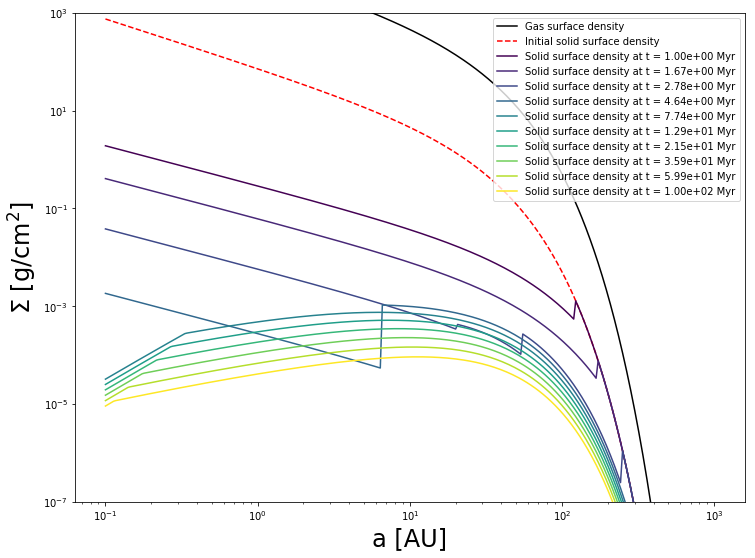

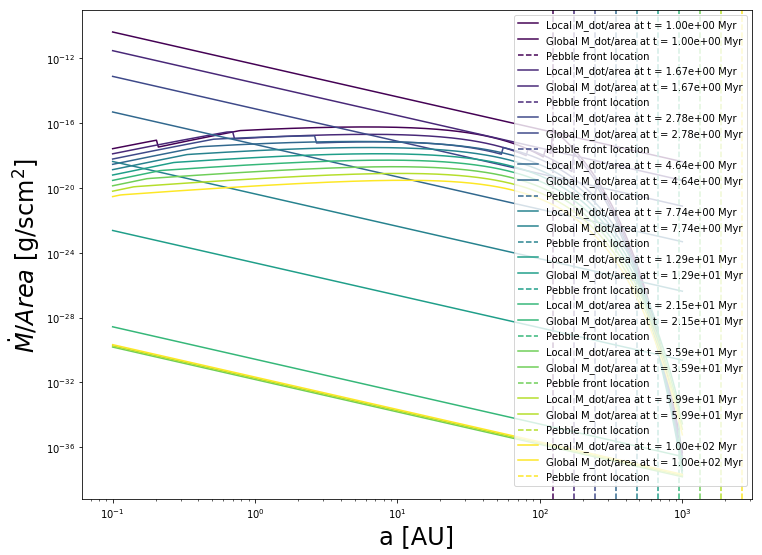

In [64]:
t_array = np.logspace(-0,2, 10) * 3.154e13
a_array = np.logspace(-1, 3, 300)

f_d = 1e-2
eps_g = 0.5
eps_d = eps_g/10
delt = 1 # Constant on drift velocity
Lamb = 1 # Constant on t_grow = Lamb * t_drift
params = 200, 1, 375, 20, 1.6, 1e-4, f_d, eps_g, eps_d, delt, Lamb
#params = 150, 1, 343, 10, 1.6, 4e-4, 100 # MMSN params
T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_g, eps_d, delt, Lamb = params
eps_p = eps_g

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
sig_d_LJ = np.zeros(sd[1].shape)

# Now, extract just the dust-to-gas, and the Sig_p arrays
sig_d_arr = np.zeros([2, t_array.size, a_array.size])
for i, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    sig_d_arr[0,i] = sig_p(f_d, a_PF, a_array, t, params)
    sig_d_arr[1,i] = dust_to_gas(t, a_PF, a_array, params) * Sig_gas


cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]

fig = plt.figure(1,figsize=(12,9))
plt.loglog(a_array, Sig_gas, 'k-', label="Gas surface density")
plt.loglog(a_array, 1e-2*Sig_gas, 'r--', label="Initial solid surface density")
for i,t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    sig_d_LJ[i] = LJ_sig_p(1e-2, a_PF, a_array, t, params)
    #plt.loglog(a_array, sig_d_LJ[i], label="LJ'14 surface density at t = {time} Myr".format(time=f"{t/3.154e13:.2e}"), color=line_colors[i])
    
    #plt.loglog(a_array, f_d_array[i]*Sig_gas, label='Solid surface density at t = {time} Myr'.format(time=f"{t/3.154e13:.2e}"), color=line_colors[i])
    
    plt.loglog(a_array, sig_d_array[i], label='Solid surface density at t = {time} Myr'.format(time=f"{t/3.154e13:.2e}"), color=line_colors[i])
    #plt.loglog(a_array, sig_d_arr[0,i], color=line_colors[i])
    #plt.loglog(a_array, sig_d_arr[1,i], color=line_colors[i])
    
plt.ylabel('$\Sigma$ $[\mathrm{g}/\mathrm{cm}^{2}]$', fontsize=24)
plt.xlabel('a [AU]', fontsize=24)
plt.ylim(1e-7,1e3)
plt.legend()
plt.show()

T = T_0 * (a_array**(-3/7))
c_s = np.sqrt((boltzmann*T)/(2.35*mH))
Om = np.sqrt((fn.G*m_star*fn.m_sun)/(a_array*fn.au)**3.)
H = c_s/Om
rhoGas = fn.gas_density(Sig_gas, H)
v_kep = Om * (a_array*fn.au)
eta = (c_s)**2/(2*(v_kep)**2)
lam_mfp = fn.mean_free_path(fn.mu,rhoGas,fn.cross)

#Sig_p_Ep = np.zeros([t_array.size,a_array.size])
#Sig_p_St = np.zeros([t_array.size,a_array.size])

a_PF_arr = np.zeros(t_array.size)
M_dot_spec = np.zeros([2, t_array.size, a_array.size])
#t_DG_arr = np.zeros([t_array.size, 2])
#s_max_arr = np.zeros([t_array.size,a_array.size, 2])
for i,t in enumerate(t_array):
    Sigma_d = sig_d_array[i]
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    a_PF_arr[i] = a_PF
    i_PF = np.argmin(abs(a_array - a_PF))
    Sig_PF = sigma[i_PF]
    M_dot = (4*np.pi)/(3) * (a_PF*fn.au)**2/t * f_d*Sig_PF
    
    M_dot_loc_specific = dust_to_gas(t, a_PF, a_array, params)*Sig_gas/t
    M_dot_glo_specific = M_dot/(2*np.pi * (a_array*fn.au)**2)
    
    M_dot_spec[0,i] = M_dot_loc_specific
    M_dot_spec[1,i] = M_dot_glo_specific
    
    #M_dot = 4 * np.pi * a_PF**2 * f_d * Sig_PF / t
    #M_dot = (2/3)**(2/3) * np.pi * (fn.G * m_star * fn.m_sun)**(1/3) * (sigma_0 * fn.au) * eps_d**(2/3) * f_d**(5/3) * t**(-1/3)
#    Sig_p_Ep[i] = np.sqrt((8 * M_dot * sigma)/(3 * np.pi**(3/2) * v_kep * a_array*fn.au))
#    Sig_p_St[i] = ((16 * fn.mu * c_s * eta * rho_int * M_dot)/(np.pi**(3/2) * fn.cross * v_kep**2))**(1/3)
    
    #s_max_arr[i,:,0] = (9 * np.sqrt(np.pi/2))/128 * (Sigma_d**2 * eps_d**2)/(alpha * rho_int * eta * sig_gas) # Max particle size in Epstein
    #s_max_arr[i,:,1] = (9 * np.pi)/(256) * (Sigma_d**2 * eps_d**2)/(alpha * eta * sig_gas**2)# Max Stokes number in Epstein
    
    #t_DG_arr[i,0] = (a_PF * fn.au) /(2 * eta[i_PF] * v_kep[i_PF] * s_max_arr[i,i_PF,1])
    #t_DG_arr[i,1] = (4/3 * np.pi * rho_int * s_max_arr[i,i_PF,0])/(eps_d * Sigma_d[i_PF]*Om[i_PF]/(2 * c_s[i_PF]) * np.sqrt(s_max_arr[i,i_PF,1]/alpha) * np.pi * 2 * eta[i_PF] * v_kep[i_PF] * s_max_arr[i,i_PF,1])
    #s_max_arr[i,:,2] = #np.sqrt(3)/8 * Sig_p_St[i]/(eta * rho_int) # Max particle size in Stokes
    #s_max_arr[i,:,3] = #1/96 * np.sqrt(np.pi/2) * Sig_p_St[i]**2 * fn.cross * Om/(fn.mu * c_s * eta**2 * rho_int) # Max Stokes number in Stokes
#Sig_p_St = ((6*np.sqrt(8)/np.pi**(3/2))*(eta**2 * rho_int * lam_mfp)/(c_s))**(1/3)

fig = plt.figure(1,figsize=(12,9))
for i,t in enumerate(t_array):
    plt.loglog(a_array, M_dot_spec[0,i], label="Local M_dot/area at t = {time} Myr".format(time=f"{t/3.154e13:.2e}"), color=line_colors[i])
    plt.loglog(a_array, M_dot_spec[1,i], label="Global M_dot/area at t = {time} Myr".format(time=f"{t/3.154e13:.2e}"), color=line_colors[i])
    plt.axvline(x=a_PF_arr[i], color=line_colors[i], label = 'Pebble front location', linestyle='--')
    
#plt.loglog(a_array, Sig_p_St, label='Solid surface density in Stokes')

#plt.loglog(a_PF_arr, t_DG_arr[:,0], label='Drift time', linestyle='--')
#plt.loglog(a_PF_arr, t_DG_arr[:,1], label='Growth time',  linestyle='-')
    #plt.loglog(a_array, f_d_array[i]*Sig_gas, label='Solid surface density at t = {time} Myr'.format(time=f"{t/3.154e13:.2e}"), color=line_colors[i])
#    plt.loglog(a_array, Sig_p_Ep[i], label='Epstein surface density at t = {time} Myr'.format(time=f"{t/3.154e13:.2e}"), color=line_colors[i], linestyle='--')
#    plt.loglog(a_array, Sig_p_St[i], label='Stokes surface density at t = {time} Myr'.format(time=f"{t/3.154e13:.2e}"), color=line_colors[i], linestyle='-.')
plt.ylabel('$\dot{M}/Area$ $[\mathrm{g}/\mathrm{s}\mathrm{cm}^{2}]$', fontsize=24)
plt.xlabel('a [AU]', fontsize=24)
#plt.ylim(1e-7,1e3)
plt.legend()
plt.show()


#a_ind = np.argmin(abs(a_array - 1)) # index of 1 AU
#i_time = 0
#M_dot = (2/3)**(2/3) * np.pi * (fn.G * m_star * fn.m_sun)**(1/3) * (sigma_0 * fn.au) * eps_d**(2/3) * f_d**(5/3) * t_array[i_time]**(-1/3)
#sig_ep_comp = M_dot/(4 * np.pi * eta[a_ind] * v_kep[a_ind] * s_max_arr[i_time, a_ind, 1] * a_array[a_ind]*fn.au)
#sig_st_comp = M_dot/(4 * np.pi * eta[a_ind] * v_kep[a_ind] * s_max_arr[i_time, a_ind, 3] * a_array[a_ind]*fn.au)
#print(Sig_p_St[i_time, a_ind], sig_st_comp)
#print(Sig_p_Ep[i_time, a_ind], sig_ep_comp)

In [223]:
# This cell calculates the location of the pebble front as it bounces back from the disk edge
params = [121, 1, 400, 20, 1.6, 1e-5]
T_0, m_star, sigma_0, r_crit, rho_int, alpha = params
t_disk = 3.1536e13 # 1 Myr
    
a_array = np.logspace(-1, 2, 300)
gamma = 1
sigma_g = sig_g(a_array, sigma_0, params)
f_d = 1e-2
t_array = np.logspace(-1,0.5, 8) * 3.154e13

#a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t_array**(2/3) / fn.au
a_PF = ((9 * np.pi * eps_d * eps_g * t_disk)/(128 * 10**4 * alpha))**(2/3) * (fn.G * m_star * fn.m_sun)**(1/3) / fn.au
t_trans = t_transition(a_array, t_array, a_PF, params)
a_edge = 100
t_edge = (16/3)**(1/2) * (eps_d * f_d)**(-1) * (fn.G * m_star * fn.m_sun)**(-1/2) * (a_edge * fn.au)**(3/2)
a_drifted = 0
a_interior = np.zeros(t_array.size)
sigma_d = np.zeros([t_array.size, a_array.size])
for i,t in enumerate(t_array):
    if t > t_trans: #if a_PF[i] > a_edge:
        # If in Powell et al. 2017 regime, find drift time for maximally size particle
        if a_interior[i-1] != 0:
            a = a_interior[i-1]
        else: a = a_edge

        j = np.argmin(abs(a - a_array))
        gamma = 1.0
        Sig = sig_g(a, sigma_0, params) #sigma_0 * ((a/r_crit)**(-gamma))*np.exp(-(a/r_crit)**(2-gamma))
        T = T_0 * (a**(-3/7))
        c_s = np.sqrt((boltzmann*T)/(2.35*mH))
        Om = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au)**3)
        v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au))
        eta = (c_s)**2/(2*(v_kep)**2)
        v0 = eta * v_kep
        St = np.sqrt(3)/8 * eps_p/eta * sig_p(f_d, a_PF[i], a_array, t, params)/Sig # Max particle size for all a, at t=t_edge
        v_drift = - 2 * v0 * (St[j]/(1 + St[j]**2))
        if i != 0:
            t_old = max(t_edge, t_array[i-1])
            t_diff = t - t_old
        else: t_diff = 0

        j = np.argmin(abs(a_edge - a_array))
        st_edge = St[j] # The maximum St at the edge of the disk, when the pebble front hits the disk edge
        s_edge = st_solver(st=st_edge, alph=alpha, a_au=a_edge, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
        t_diff_arr = np.linspace(t_old, t_diff, 1000)
        a_diff_arr = np.zeros(t_diff_arr.size)
        for k, t_d in enumerate(t_diff_arr):
            if k == 0:
                st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            elif a_drifted < a:
                T = T_0 * (a_new**(-3/7))
                c_s = np.sqrt((boltzmann*T)/(2.35*mH))
                Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au)**3)
                v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au))
                eta = (c_s)**2/(2*(v_kep)**2) #0.0015 * a_new**(1/2)t
                v0 = eta * v_kep
                st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a_new,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            else:
                st_diff = st_rad(rad=s_edge,alph=alpha,a_au=0.0001,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            v_drift = - 2 * v0 * (st_diff/(1 + st_diff**2))
            if k == 0:
                a_diff_arr[0] = v_drift * (t_diff_arr[1] - t_d) / fn.au
                a_drifted = abs(a_diff_arr[0])
                a_new = a - a_drifted
            elif a_drifted < a:
                a_diff_arr[k] = v_drift * (t_d - t_diff_arr[k-1]) / fn.au
                a_drifted = a_drifted + abs(a_diff_arr[k])
                a_new = a - a_drifted
            else:
                a_new = 0.0001
        # Finds the locations to which maximally sized particles have drifted by new disk time
        a_interior[i] = a_new #a - abs(v_drift * t_diff)/fn.au

print(a_interior)

NameError: name 't_transition' is not defined

In [ ]:
## Plotting m_dot comparison
t_array = np.linspace(0.1, 1, 10) * 3.154e13 #np.logspace(-1,0.5, 16) * 3.154e13
line_colors = [sm.to_rgba(t) for t in t_array]
a_array = np.logspace(0, 3, 300)
M_dot_arr = np.zeros([a_array.size, t_array.size, 2])
sig_d_array = np.zeros([t_array.size, a_array.size])
#params = [T_0, m_star, sig_0, r_crit, rho_int, alpha, a_edge]
params = 200, 1, 375, 20, 1.6, 1e-4
eps_g = 0.5
eps_d = 0.5/10
sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
a_PF_arr = np.zeros(t_array.size)

T_0, m_star, sigma_0, r_crit, rho_int, alpha = params
temp_arr = np.zeros([t_array.size, a_array.size])
for k, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    a_PF_ind = np.argmin(abs(a_array - a_PF))
    a_PF_arr[k] = a_PF
    for j, a_au in enumerate(a_array):
        sig_gas = Sig_gas[j]
        sig_d = sig_d_array[k,j]
        sig_gas_PF = Sig_gas[a_PF_ind]
        temp = T_0*a_au**(-3./7.)
        temp_arr[k,j] = temp
        c_s = fn.sound_speed(temp)
        v_th = np.sqrt(8/np.pi)*c_s
        v_k = fn.vkep(m_star*fn.m_sun, a_au*fn.au)
        Om = v_k/(a_au*fn.au)
        rho_gas = sig_gas * Om/(2*c_s)
        eta = fn.eta(c_s, v_k)
        v_0 = eta * v_k
        v_g = np.sqrt(v_0**2 + (np.sqrt(alpha) * c_s)**2)
        lambda_mfp = fn.mean_free_path(fn.mu,rho_gas,fn.cross)
        nu = lambda_mfp*np.sqrt(8/np.pi)*c_s
        Re = (v_g**2)/(nu*Om) #(alpha*c_s**2)/(nu*Om)
        #print("Reynolds number is ", Re)

        if a_PF > a_edge:
            St = (a_au*fn.au)/(2 * v_g * t)
            s = st_solver(st=St, alph=alpha, a_au=a_au, m_suns=m_star, m_earths=1, temp_in=temp, sig_in=sig_gas)
        else:
            #s = 3*np.sqrt(2)/16 * sig_d/(eta*rho_int)
            #St = 3*np.sqrt(np.pi)/16 * sig_d/(eta * sig_gas) #Om*fn.ts_eps(rho_int, rho_gas, s, v_th) #st_rad(rad=s,alph=alpha,a_au=a_au,m_suns=m_star,m_earths=1,sig_in=sig_gas,temp_in=temp)
            # Assuming laminar velocity is the relative velocity
            s = (9 * np.sqrt(np.pi/2))/128 * (sig_d**2 * eps_g**2)/(alpha * rho_int * eta * sig_gas)
            St = (9 * np.pi)/(256) * (sig_d**2 * eps_g**2)/(alpha * eta * sig_gas**2)
            # Assuming turbulent velocity instead
            #s = (9 * np.sqrt(np.pi))/512 * (np.pi/8)**(1/4) * np.sqrt(fn.cross/fn.mu) * (sig_d**2 * np.sqrt(alpha)  * v_kep**4)/(c_s**4 * rho_int * np.sqrt(sig_gas))
            #St = (9 * np.pi)/(512 * np.sqrt(2)) * (np.pi/8)**(1/4) * np.sqrt(fn.cross/fn.mu) * (sig_d**2 * np.sqrt(alpha)  * v_kep**4)/(c_s**4 * sig_gas**(3/2))
        
        m = 4/3 * np.pi * s**3 * rho_int
        m_dot_global = 4 * np.pi/3 * ((a_PF*fn.au)**2 / t) * f_d * sig_gas_PF / (a_au*fn.au)**2
        #m_dot_local = sig_d * (Om/(2*c_s)) * np.sqrt(St/alpha) * np.pi * s**2 * (c_s * np.sqrt(2 * St * alpha)) * sig_d/m
        m_dot_local = sig_d * (Om/(2*c_s)) * np.sqrt(St/alpha) * np.pi * s**2 * (2 * eta * v_kep * St) * sig_d/m # Assume laminar velocity
        #m_dot_local = np.sqrt(a_PF)/200 * sig_d * (Om/(2*c_s)) * np.sqrt(St/alpha) * np.pi * s**2 * (St/2 * np.sqrt(alpha) * c_s * (alpha * c_s/(fn.mean_free_path(fn.mu,sig_gas,fn.cross) * v_th * Om))**(1/4)) * sig_d/m # Assume turbulent velocity
        M_dot_arr[j,k,0] = m_dot_global
        M_dot_arr[j,k,1] = m_dot_local

fig = plt.figure(1,figsize=(12,9))
for i,t in enumerate(t_array):
    plt.vlines(a_PF_arr[i], 10**-20, 1, color=line_colors[i], linewidth=2, linestyle='-.')
    plt.loglog(a_array, M_dot_arr[:,i,0], label='t = {time} Myr'.format(time=f"{t/3.154e13:.2n}"), linewidth=3, color=line_colors[i], linestyle='--')
    plt.loglog(a_array, M_dot_arr[:,i,1], label='t = {time} Myr'.format(time=f"{t/3.154e13:.2n}"), linewidth=3, color=line_colors[i], linestyle='-')
plt.ylabel('$\dot{M}$')#, **axis_font)
plt.xlabel('a [AU]')#, **axis_font)
plt.xlim(1e0, 2e2)
plt.ylim(1e-18, 1e-8)
plt.legend(loc=1, bbox_to_anchor=(1.25, 1., 0., 0.), fontsize='x-large')
plt.show()

(10, 100)

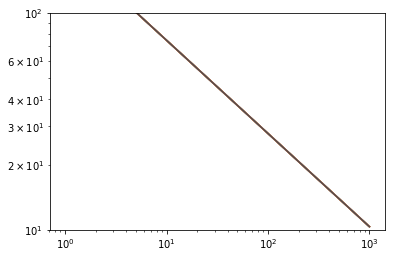

In [7]:
for i,t in enumerate(t_array):
    plt.loglog(a_array, temp_arr[i])
plt.ylim(10,100)

In [8]:
t_array = np.linspace(0.001, 1, 1000) * 3.154e13
a_PF_arr = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t_array**(2/3) / fn.au
print(t_array.size, a_PF_arr.size)
print(t_transition(a_array, t_array, a_PF_arr, params) / 3.154e13)

1000 1000
0.001
